In [1]:
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from copy import copy
import yaml

In [2]:
#!pip install -U sentence-transformers
!pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113 --user 


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113


In [2]:
#local
%cd "G:\Meu Drive\Obsidian\Ios3\areas\doutorado\tools"

G:\Meu Drive\Obsidian\Ios3\areas\doutorado\tools


In [3]:
!dir

 O volume na unidade G ‚ Google Drive
 O N£mero de S‚rie do Volume ‚ 1983-1116

 Pasta de G:\Meu Drive\Obsidian\Ios3\areas\doutorado\tools

08/12/2022  15:13    <DIR>          .
06/07/2023  16:34    <DIR>          ..
17/09/2022  16:33    <DIR>          teste grafo
26/10/2022  19:53    <DIR>          skills
17/09/2022  17:25               150 exportacsv.py
19/06/2023  18:31    <DIR>          F1
28/09/2022  11:32    <DIR>          F2
29/09/2022  16:11            74.584 palvras.csv
05/10/2022  18:51             2.288 Untitled-1.sty
05/10/2022  19:48                 0 4.0.0
19/10/2022  16:29            96.088 save_as_a_png.png
19/10/2022  16:34            25.496 swarm.png
02/01/2023  15:39    <DIR>          finetuning-sentiment-model-3000-samples
12/10/2022  19:15             1.977 wordcloud.png
12/10/2022  19:21           270.681 wordcloyd.png
20/10/2022  10:33            33.076 multipage_pdf.pdf
23/10/2022  11:27    <DIR>          TBXPC
13/11/2022  13:45                 0 demo_compact.ht

# Carrega dados

In [18]:
PASTA = 'F1/'

#load mechanics from csv
#GM
dfGM = pd.read_csv(PASTA + 'gm_novos_textos.csv',delimiter='|')
#dfGM = pd.read_csv(PASTA + 'gm__antes_das_adicoes.csv',delimiter='|')
#dfGM = pd.read_csv(PASTA + 'gm_gpt.csv',delimiter='|')

#dfGM["Combined"] = dfGM['Mechanics'].astype(str) +": " + dfGM["Description"]
dfGM['type'] = 'GM'
#dfGM.drop(['Description'], axis=1, inplace=True)
dfGM.reset_index(drop=True)
#dfGM.set_index(["Description", "Mechanics"], inplace = True, append = True, drop = False)

#PC
#Computational Thinking Lines
  #pc_silvajuniorbraz.csv  (linhas do autor: 4.5.2. em diante)
  #pclf.csv                (G. Computational Thinking Lines)
#GGasCT: Bringing Formal Methods to the Computational Thinking:
#pc.csv: linhas (texto longo)
#pc2.csv: termos 
#pc3.csv: pc.csv resumido - parte final
#pclf_linhas_bras a partir da pagina 8 Computational Thinking Lines: A Literature Review to Connect all the Dots

dfPC = pd.read_csv(PASTA + 'pclf_linhas_bras.csv',delimiter='|')
#dfPC = pd.read_csv(PASTA + 'pclf.csv',delimiter='|')
#dfPC = pd.read_csv(PASTA + 'newdec.csv',delimiter='|')
#dfPC = pd.read_csv(PASTA + 'pc_titulos.csv',delimiter='|')

#dfPC["Combined"] = dfPC['Mechanics'].astype(str) +": " + dfPC["Description"]
dfPC['type'] = 'PC'
#dfPC.drop(['Description'], axis=1, inplace=True)
dfPC = dfPC.reset_index(drop=True)
dfPC.sort_values(['Mechanics'], ascending=True, inplace=True)

dfPC

,Mechanics,Description,Score,type
0,Abstraction,Abstraction We see abstraction being treated m...,0,PC
1,Algorithm,Algorithm Algorithms are commonly approached h...,0,PC
2,Automation,Automation Our vision is that what is importan...,0,PC
3,Data,Data If we consider “datum” a unit of informat...,0,PC
4,Decomposition,Decomposition Our vision of this concept is th...,0,PC
5,Evaluation,Evaluation From the word history we could see ...,0,PC


# Monta vetores

In [19]:
textoGM = []
for index, row in dfGM.iterrows():
  textoGM.append(row['Description'])

mecanicasGM = []
for index, row in dfGM.iterrows():
  mecanicasGM.append(row['Mechanics'])


textoPC = []
for index, row in dfPC.iterrows():
  textoPC.append(row['Description'])

mecanicasPC = []
for index, row in dfPC.iterrows():
  mecanicasPC.append(row['Mechanics'])



# Calcula

In [30]:
from sentence_transformers import SentenceTransformer, util
import seaborn as sns
#for long passages
MODELSDOT = ['msmarco-distilbert-base-dot-prod-v3','multi-qa-MiniLM-L6-dot-v1','multi-qa-distilbert-dot-v1','multi-qa-mpnet-base-dot-v1','sentence-transformers/multi-qa-mpnet-base-dot-v1']
#for short passages 
#            0                     1                           2  (paraphrase)                         3                   4                   5                   6                       7                        8                                           11
MODELSCOS = ['allenai-specter','msmarco-MiniLM-L12-cos-v5','distiluse-base-multilingual-cased-v1','stsb-roberta-large','all-MiniLM-L6-v2','all-mpnet-base-v2','msmarco-MiniLM-L-6-v3','msmarco-roberta-base-v3','all-mpnet-base-v2',
             'gtr-t5-xl','distilbert-base-uncased','sentence-transformers/gtr-t5-large','bert-large-uncased','bert-base-cased','sentence-transformers/bert-base-nli-mean-tokens','xlm-roberta-large','bert-large-cased','distilbert-base-uncased','Maite89/Roberta_finetuning_semantic_similarity_stsb_multi_mt','Sakil/sentence_similarity_semantic_search']
#                 9           10                                          11                       12                      13                           14                     15                     16       17                            18                                                              19
#resultados COS
#modelo   #resultados   #limiar    
#0         156          0.7
#1         12           0.2
#2         23           0.2 
#3         110          0.2 *
#4         37           0.2
#5         61           0.2
#6         27           0.2
#7         4            0.2      
#8         61           0.2
#9         156          0.5
#14 https://towardsdatascience.com/bert-for-measuring-text-similarity-eec91c6bf9e1

modeloEscolhido = 9
model = SentenceTransformer(MODELSCOS[modeloEscolhido],device="cuda") 

#retira / caso tenha no nome do modelo
MODELSCOS[modeloEscolhido] = MODELSCOS[modeloEscolhido].replace('/','_')

aux =[]
#teste com status (GM)
#emb1 = model.encode("Provides a sense of belonging or meaningful empowerment. Multiple forms of status, such as titles, levels, tiers, rank not just globally but also locally within a community")
for P in textoPC:
  emb1 = model.encode(P,convert_to_tensor=True)
  mPC = dfPC.loc[dfPC['Description'] == P].Mechanics.item()
  for G in textoGM:
    mGM = dfGM.loc[dfGM['Description'] == G].Mechanics.item()
    emb2 = model.encode(G, convert_to_tensor=True)
    s = util.cos_sim(emb1, emb2)
    #s = util.dot_score(emb1, emb2)
    s = s.item()
    aux.append([mPC,"GM",mGM,G,s,MODELSCOS[modeloEscolhido]])
#print("total:",conta)
df = pd.DataFrame(aux,columns=['PC','type','Mechanics','Mech_desc','score','modelo'])


#pega somene o valor mais alto de cada mecanica
df = df.loc[df['score'] >= 0.51] 
df = df.loc[df.groupby(['Mechanics'])['score'].idxmax()] 
df = df.sort_values('score')


df.to_excel(PASTA + "xlsx/bertGM_" + MODELSCOS[modeloEscolhido] + ".xlsx")




In [31]:
df

,PC,type,Mechanics,Mech_desc,score,modelo
69,Automation,GM,Infinite Gameplay,Games that have no explicit end. Most applicab...,0.513511,gtr-t5-xl
43,Algorithm,GM,Ownership (GM),Used to create loyalty of the gaming pool. The...,0.519075,gtr-t5-xl
144,Decomposition,GM,Virality,Mechanics to grow player base which if done ri...,0.527893,gtr-t5-xl
110,Data,GM,Status,Provides a sense of belonging or meaningful em...,0.535715,gtr-t5-xl
16,Abstraction,GM,Pavlovian Interaction,"Follows the methodology ‘easy to learn, hard t...",0.536609,gtr-t5-xl
85,Automation,GM,Urgent Optimism,Used to elicit a desire to act immediately to ...,0.542224,gtr-t5-xl
141,Decomposition,GM,Tile-Laying,Often drawn by the player for strategic positi...,0.547916,gtr-t5-xl
12,Abstraction,GM,Meta-Game Mechanic,Rewards or improvements that can be earned dur...,0.557668,gtr-t5-xl
82,Automation,GM,Maneuvering (Physical Movement),Controlling the movement of game elements in r...,0.557763,gtr-t5-xl
118,Decomposition,GM,Behavioral Momentum,Used to give confidence and motivate players t...,0.558755,gtr-t5-xl


In [33]:
df = df.loc[df['PC'] == 'Decomposition'] 

In [34]:
df

,PC,type,Mechanics,Mech_desc,score,modelo
144,Decomposition,GM,Virality,Mechanics to grow player base which if done ri...,0.527893,gtr-t5-xl
141,Decomposition,GM,Tile-Laying,Often drawn by the player for strategic positi...,0.547916,gtr-t5-xl
118,Decomposition,GM,Behavioral Momentum,Used to give confidence and motivate players t...,0.558755,gtr-t5-xl
123,Decomposition,GM,Competition,Competition could mean a player against the ot...,0.586015,gtr-t5-xl
125,Decomposition,GM,Design-editing,We define this game mechanics as the possibili...,0.591394,gtr-t5-xl
142,Decomposition,GM,Tokens to Act as Cards or Random Elements,To add the element of surprise and act as a ra...,0.605047,gtr-t5-xl
138,Decomposition,GM,Role Playing,Rely on mechanics to establish the effectivene...,0.610298,gtr-t5-xl
122,Decomposition,GM,Communal Discovery,Involves an entire community working together ...,0.632434,gtr-t5-xl
129,Decomposition,GM,Tile Based Movement,This game mechanics refers to how players move...,0.635381,gtr-t5-xl


In [35]:
df.loc[df.Mechanics == 'Tokens to Act as Cards or Random Elements', 'Mechanics'] = 'Random Elements'
df

,PC,type,Mechanics,Mech_desc,score,modelo
144,Decomposition,GM,Virality,Mechanics to grow player base which if done ri...,0.527893,gtr-t5-xl
141,Decomposition,GM,Tile-Laying,Often drawn by the player for strategic positi...,0.547916,gtr-t5-xl
118,Decomposition,GM,Behavioral Momentum,Used to give confidence and motivate players t...,0.558755,gtr-t5-xl
123,Decomposition,GM,Competition,Competition could mean a player against the ot...,0.586015,gtr-t5-xl
125,Decomposition,GM,Design-editing,We define this game mechanics as the possibili...,0.591394,gtr-t5-xl
142,Decomposition,GM,Random Elements,To add the element of surprise and act as a ra...,0.605047,gtr-t5-xl
138,Decomposition,GM,Role Playing,Rely on mechanics to establish the effectivene...,0.610298,gtr-t5-xl
122,Decomposition,GM,Communal Discovery,Involves an entire community working together ...,0.632434,gtr-t5-xl
129,Decomposition,GM,Tile Based Movement,This game mechanics refers to how players move...,0.635381,gtr-t5-xl


# Relatório

In [8]:
df.describe()

,score
count,29.000000
mean,0.580237
std,0.036829
min,0.513511
25%,0.557668
50%,0.584663
75%,0.605047
max,0.648183


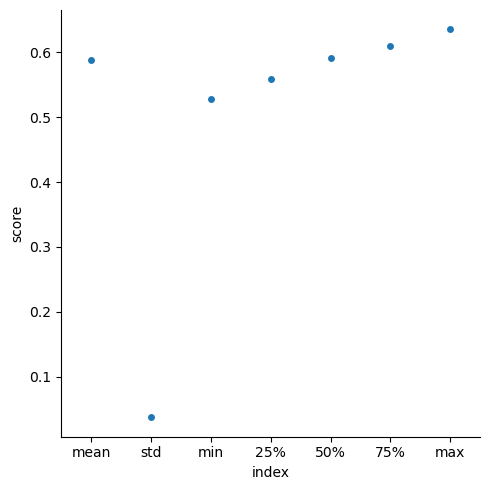

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

total_columns = df.columns
# store numerical and categorical column in two different variables. It comes handy during visualizaion.
num_col = df._get_numeric_data().columns
cat_col = list(set(total_columns)-set(num_col))

describe_num_df = df.describe(include=['int64','float64'])
describe_num_df.reset_index(inplace=True)
# To remove any variable from plot
describe_num_df = describe_num_df[describe_num_df['index'] != 'count']
for i in num_col:
  if i in ['index']:
    continue
  sns.catplot(x='index', y=i, data=describe_num_df)
  #plt.show()
  plt.savefig(PASTA + 'describe.pdf', bbox_inches='tight')

<AxesSubplot:>

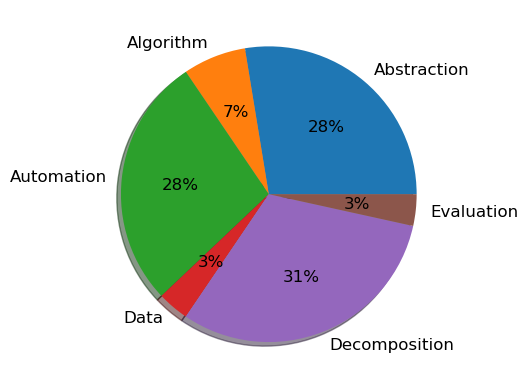

In [10]:
from matplotlib.pyplot import pie, axis, show

df.groupby('PC').size().plot(kind='pie', textprops={'fontsize': 12,'color':'k'}, autopct='%1.0f%%',ylabel='',shadow=True)

colors = {
  "Evaluation":"maroon",
  "Decomposition":"green",
  "Abstraction":"#9467bd",
  "Data":"#d62728",
  "Algorithm":"darkorange",
  "Automation":"#1f77b4"
}
# Graficos

In [12]:
colors = {
  "Evaluation":"maroon",
  "Decomposition":"green",
  "Abstraction":"#9467bd",
  "Data":"#d62728",
  "Algorithm":"darkorange",
  "Automation":"#1f77b4"
}


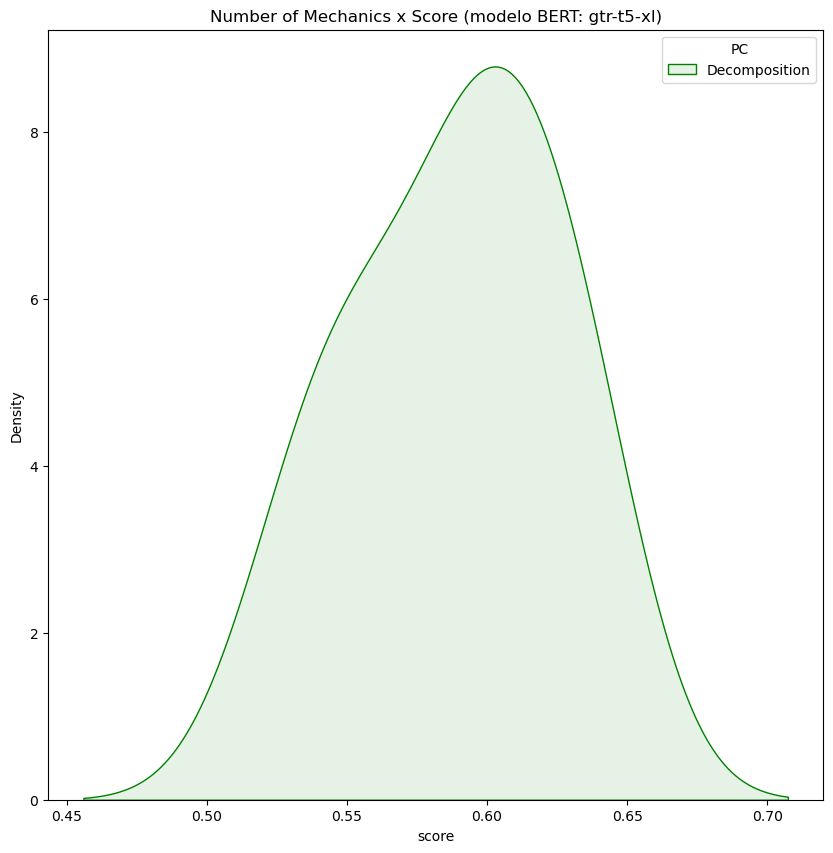

In [13]:
from matplotlib.backends.backend_pdf import PdfPages
#df = dfPrimeiro.copy('deep')
f, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Number of Mechanics x Score (modelo BERT: " + MODELSCOS[modeloEscolhido] + ")")


ax = sns.kdeplot(
   data=df, x="score", hue="PC",
   fill=True, common_norm=False, palette=colors,warn_singular=True,alpha=.1, linewidth=1,
)
plt.savefig(PASTA + MODELSCOS[modeloEscolhido] + '_kdeplot.pdf', bbox_inches='tight')



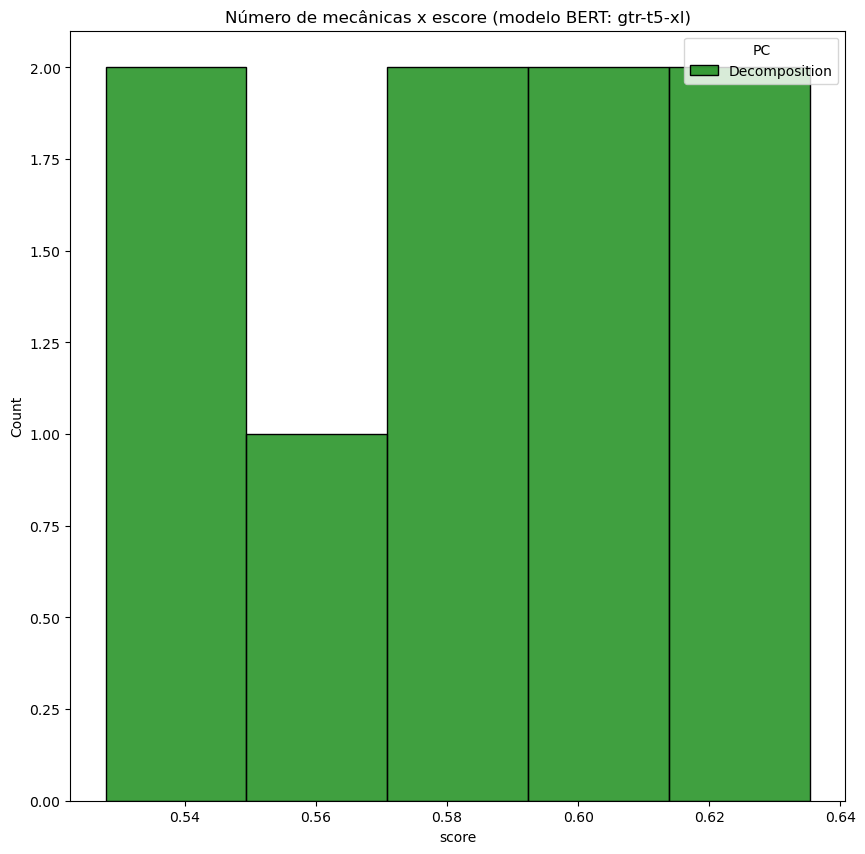

In [14]:
from matplotlib.backends.backend_pdf import PdfPages
#df = dfPrimeiro.copy('deep')
f, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Número de mecânicas x escore (modelo BERT: " + MODELSCOS[modeloEscolhido] + ")")

ax = sns.histplot(data=df,x='score',hue='PC', multiple="stack",palette=colors) #,element="step"
plt.savefig(PASTA + MODELSCOS[modeloEscolhido] + '_ct_score_histplot.pdf', bbox_inches='tight')

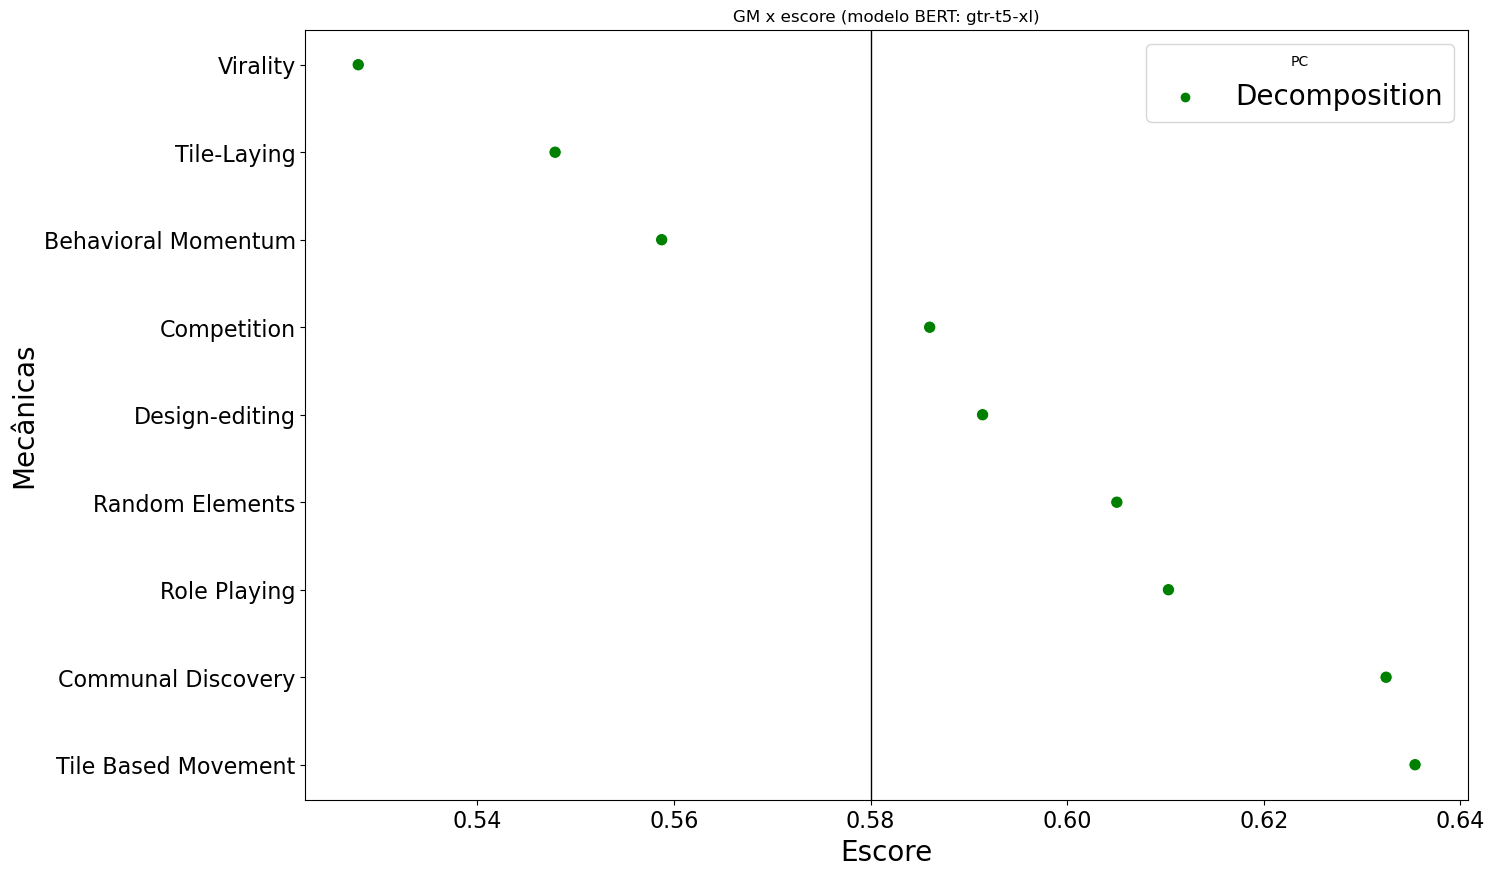

In [36]:
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.collections import LineCollection
#df = dfPrimeiro.copy('deep')
f, ax = plt.subplots(figsize=(15, 10))
ax.set_title("GM x escore (modelo BERT: " + MODELSCOS[modeloEscolhido] + ")")

#linhas
l1 = [(0.58,-20), (0.58, 100)]
l2 = [(0.50, 14), (100, 14)]
lc = LineCollection([l1, l2], color=["k","k"], lw=1)
plt.gca().add_collection(lc)



# Draw a categorical scatterplot to show each observation
ax = sns.scatterplot(data=df, x="score", y="Mechanics", hue="PC",s=80, palette=colors)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylabel('Mecânicas', fontsize=20)
plt.xlabel('Escore', fontsize=20)
plt.legend(title='PC', fontsize=20)

plt.savefig(PASTA + MODELSCOS[modeloEscolhido] + '_swarmplot.pdf', bbox_inches='tight')


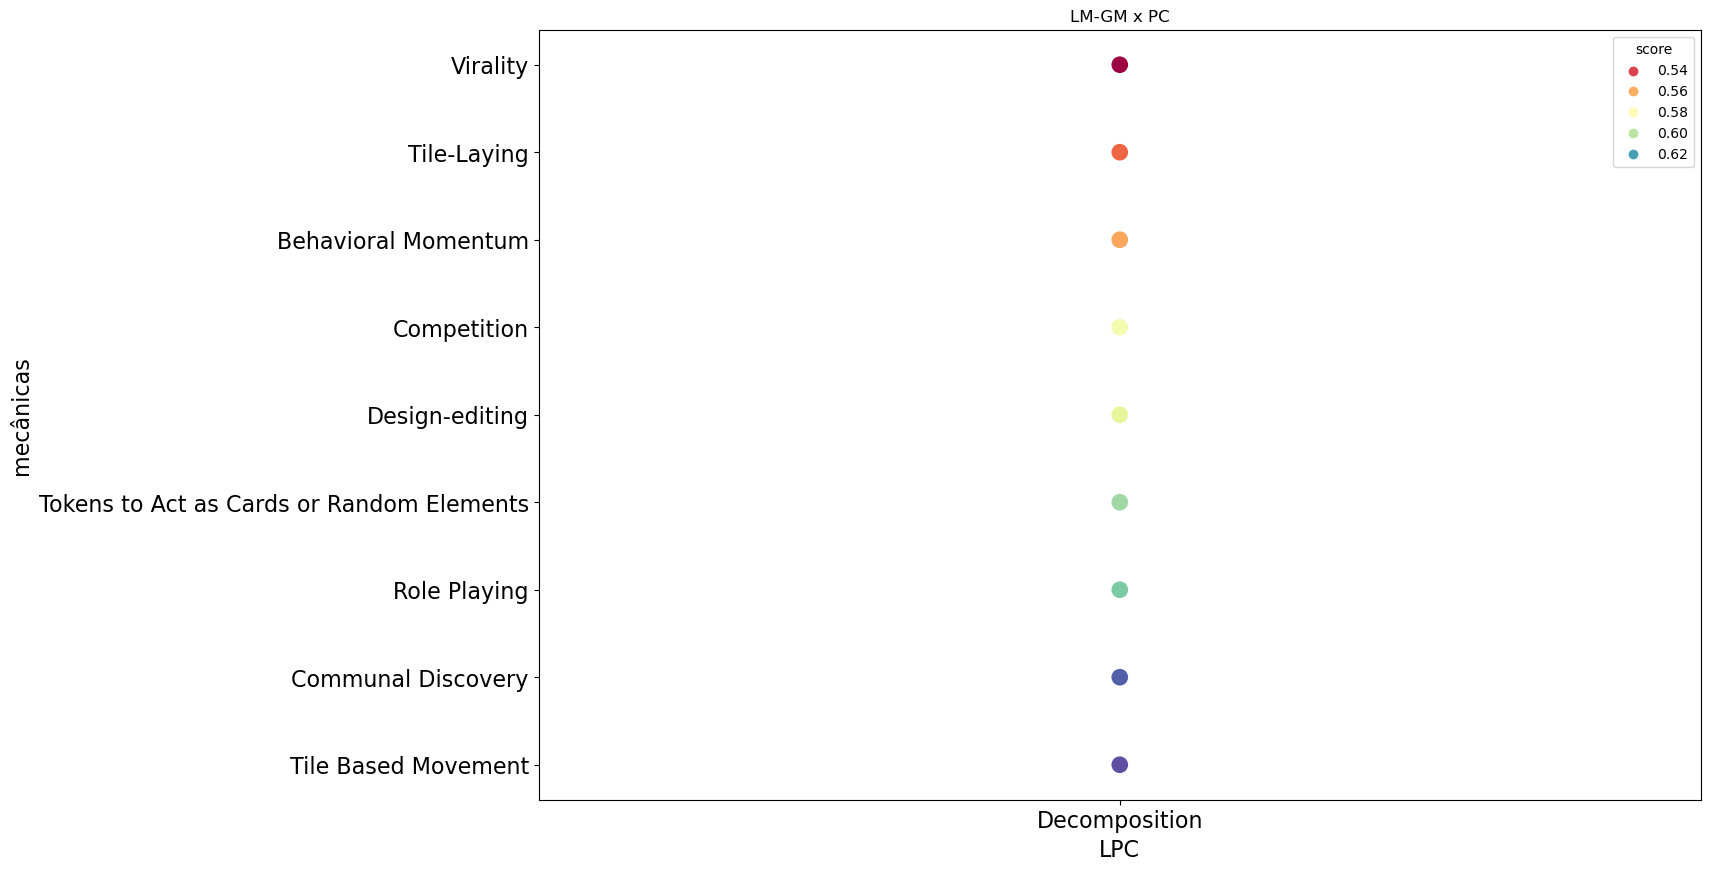

In [34]:
df = df.sort_values('score')


#df = dfPrimeiro.copy('deep')
# Draw a heatmap with the numeric values in each cell
#dados = df.pivot('GM', 'PC', 'score')
f, ax = plt.subplots(figsize=(15, 10))
ax.set_title("LM-GM x PC")


#linhas
l1 = [(-10, 24.5), (100, 24.5)]
lc = LineCollection([l1], color=["k"], lw=1)
plt.gca().add_collection(lc)

ax = sns.swarmplot(data=df, x="PC", y="Mechanics", hue="score",size=12,palette="Spectral")


plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 

plt.ylabel('mecânicas', fontsize=16)
plt.xlabel('LPC', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.savefig(PASTA + MODELSCOS[modeloEscolhido] + '_swarmplot_hue_score.pdf', bbox_inches='tight')

# Wordcloud

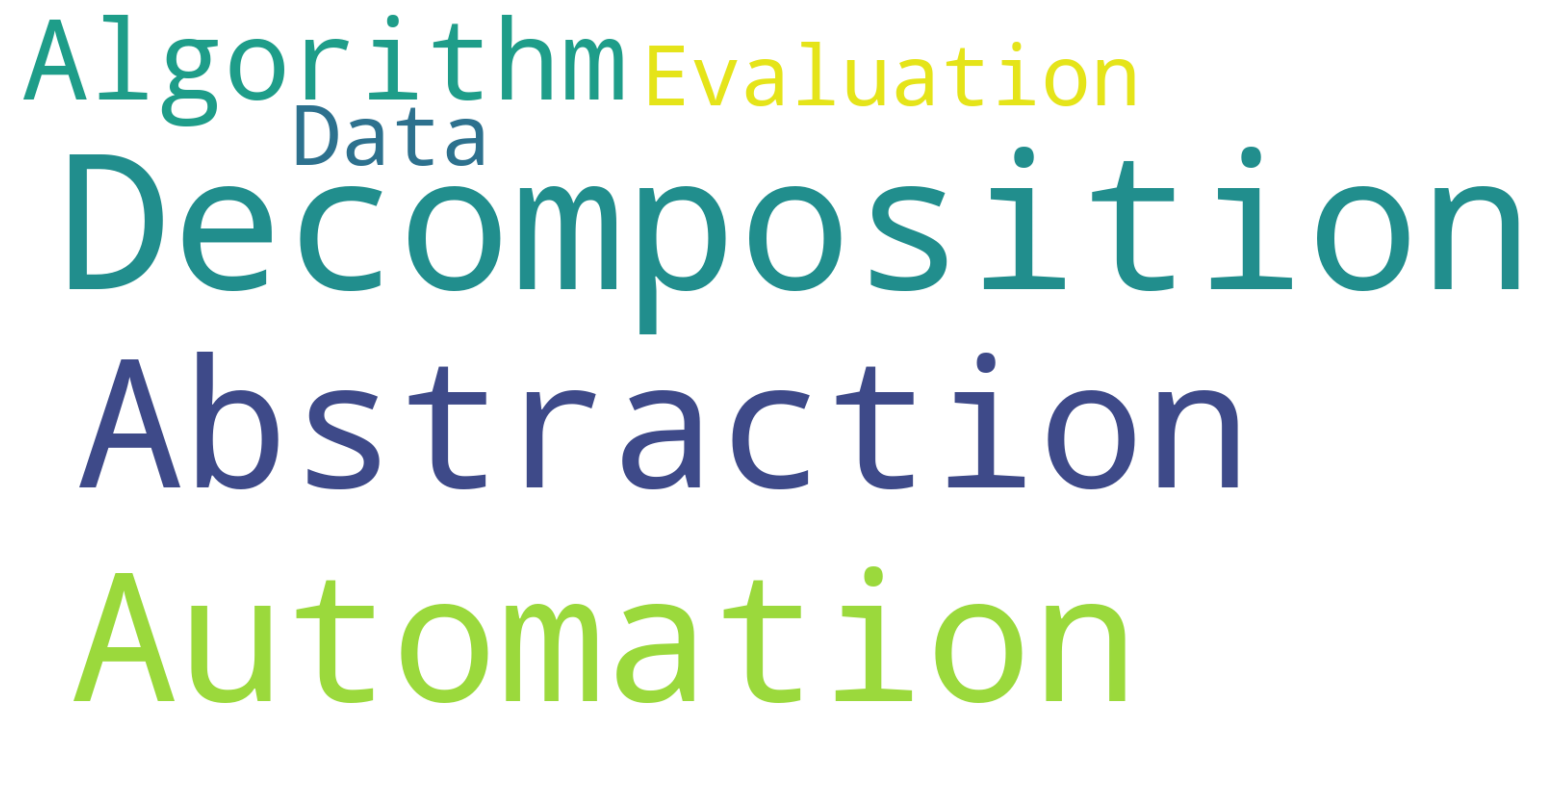

<Figure size 640x480 with 0 Axes>

In [16]:
#Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
from matplotlib.pyplot import figure
#Importing Dataset

#df = dfPrimeiro.copy('deep')
#Creating the text variable

text2 = " ".join(PC for PC in df.PC)

# Creating word_cloud with text as argument in .generate() method

word_cloud2 = WordCloud(width=1600, height=800,collocations = False, background_color = 'white').generate(text2)

# Display the generated Word Cloud
plt.figure(figsize=(20,10))
plt.imshow(word_cloud2, interpolation='bilinear')
plt.axis("off")
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig(PASTA + MODELSCOS[modeloEscolhido] + '_wordcloud.pdf', bbox_inches='tight', dpi=300)

# Wordcloud Mech_desc

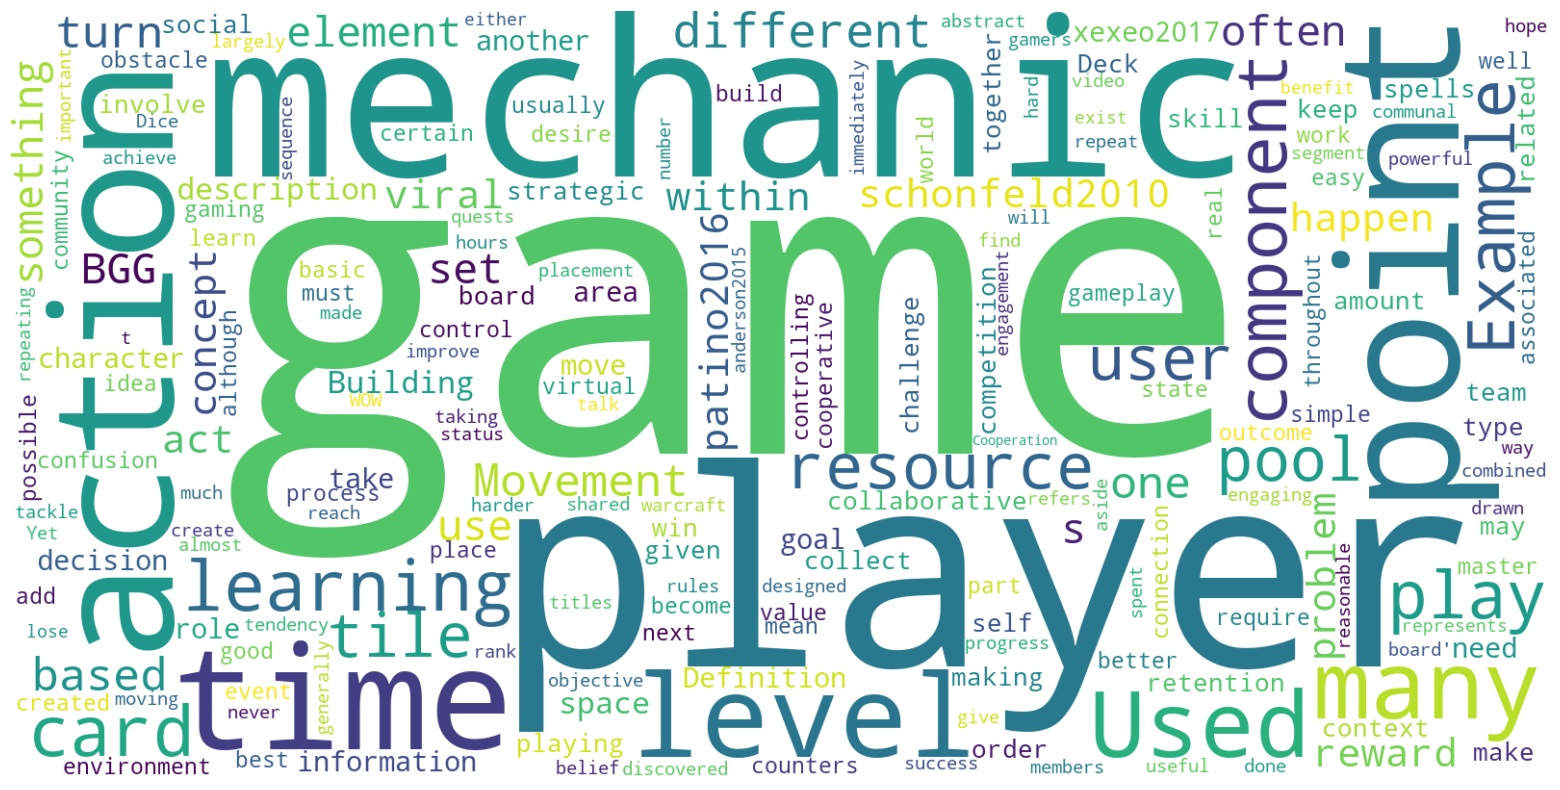

<Figure size 640x480 with 0 Axes>

In [17]:
#Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
from matplotlib.pyplot import figure
#Importing Dataset

#df = dfPrimeiro.copy('deep')
#Creating the text variable

text2 = " ".join(Mech_desc for Mech_desc in df.Mech_desc)

# Creating word_cloud with text as argument in .generate() method

word_cloud2 = WordCloud(width=1600, height=800,collocations = False, background_color = 'white').generate(text2)


# Display the generated Word Cloud
plt.figure(figsize=(20,10))
plt.imshow(word_cloud2, interpolation='bilinear')
plt.axis("off")
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig(PASTA + MODELSCOS[modeloEscolhido] + '_wordcloud2.pdf', bbox_inches='tight', dpi=300)

# Wordcloud PC

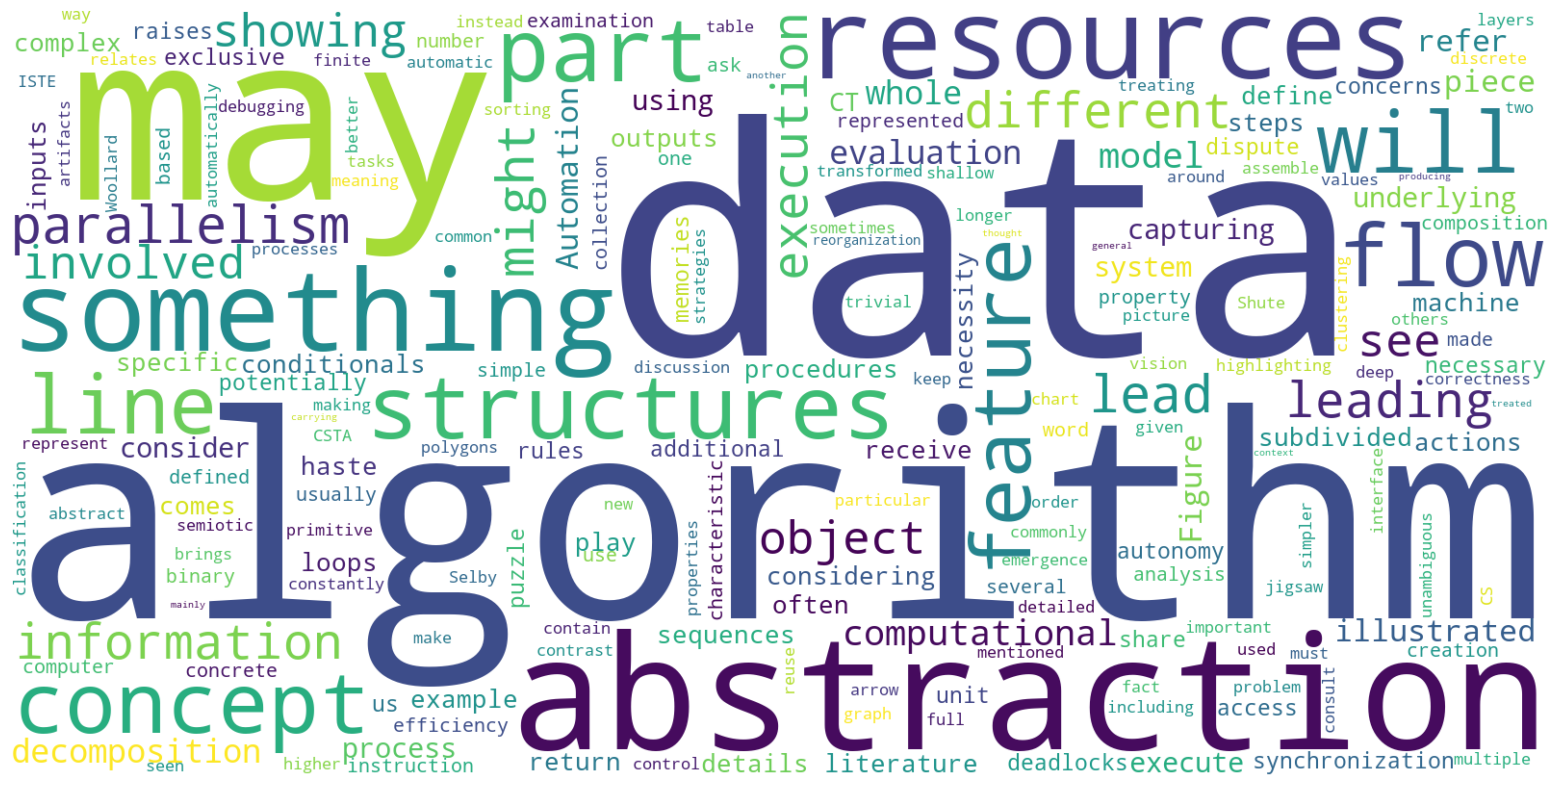

<Figure size 640x480 with 0 Axes>

In [21]:
#Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
from matplotlib.pyplot import figure
#Importing Dataset

#df = dfPrimeiro.copy('deep')
#Creating the text variable

text2 = " ".join(Description for Description in dfPC.Description)

# Creating word_cloud with text as argument in .generate() method

word_cloud2 = WordCloud(width=1600, height=800,collocations = False, background_color = 'white').generate(text2)


# Display the generated Word Cloud
plt.figure(figsize=(20,10))
plt.imshow(word_cloud2, interpolation='bilinear')
plt.axis("off")
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig(PASTA + MODELSCOS[modeloEscolhido] + '_wordcloud2.pdf', bbox_inches='tight', dpi=300)

# heatmap 

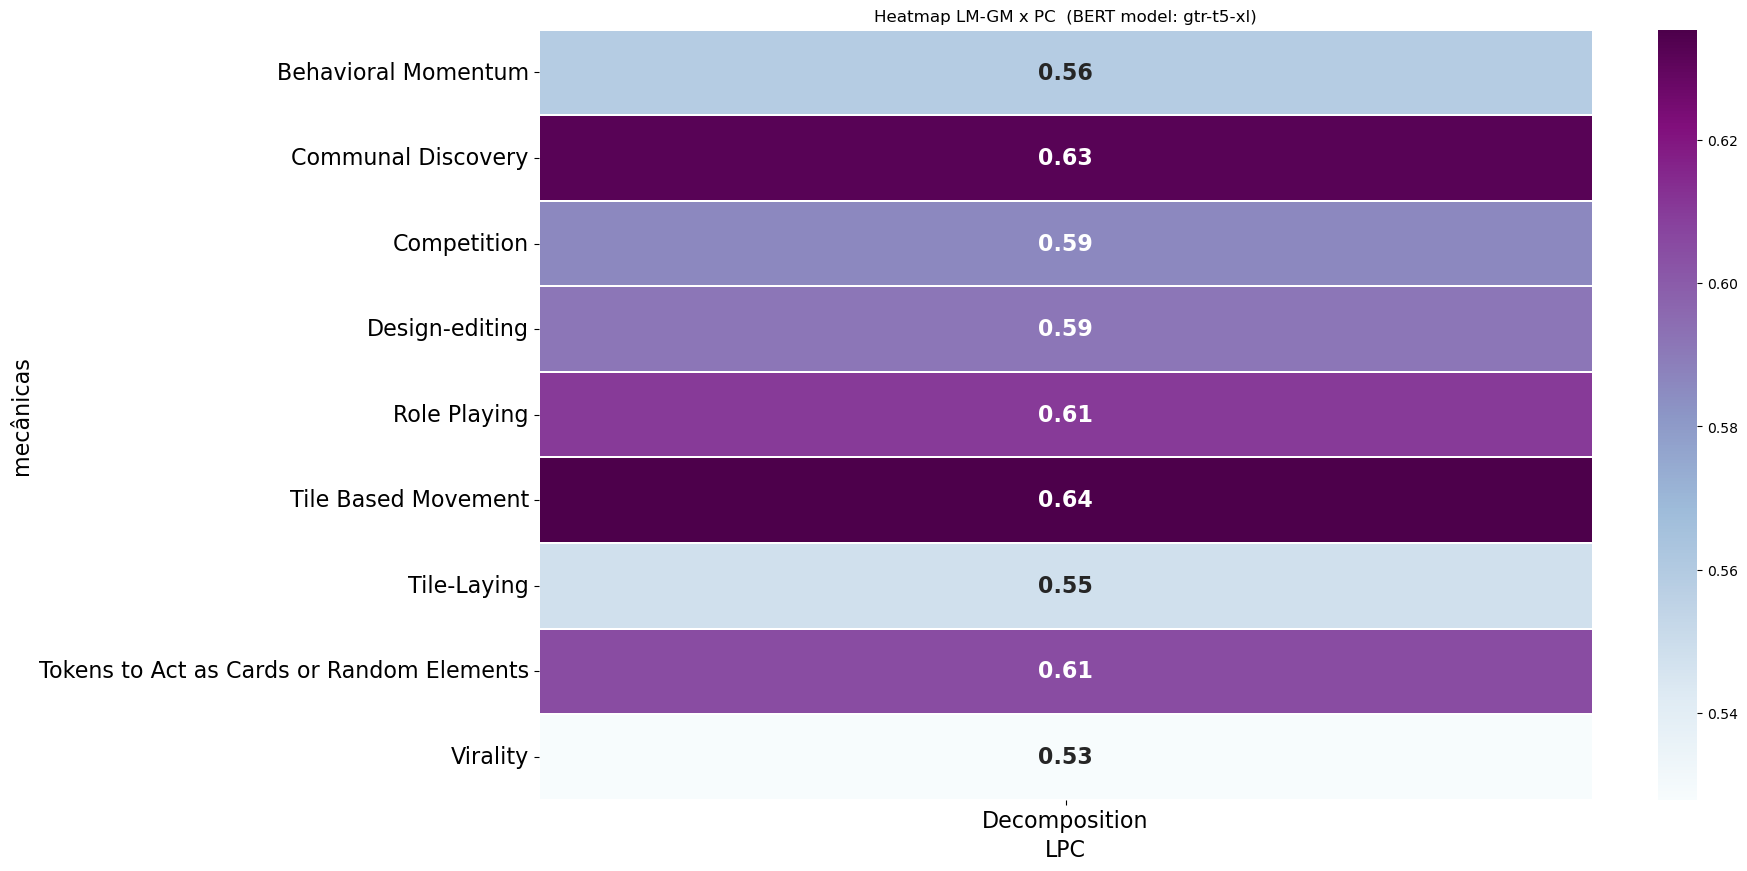

In [23]:
df = df.sort_values('score')
# Draw a heatmap with the numeric values in each cell
#df = dfPrimeiro.copy('deep')
dados = df.pivot('Mechanics', 'PC', 'score')
f, ax = plt.subplots(figsize=(17, 10))
ax.set_title("Heatmap LM-GM x PC  (BERT model: " + MODELSCOS[modeloEscolhido] + ")")
sns.heatmap(dados, annot=True, linewidths=.1, ax=ax,cmap="BuPu", annot_kws={
                'fontsize': 16,
                'fontweight': 'bold',
            })
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('LPC', fontsize=16);
plt.ylabel('mecânicas', fontsize=16);

plt.savefig(PASTA + MODELSCOS[modeloEscolhido] + '_heatmap.pdf', bbox_inches='tight', dpi=300)

In [19]:
Teste

NameError: name 'Teste' is not defined

In [ ]:
from sentence_transformers import SentenceTransformer, util

query = "Is this related to decomposition?"
docs = ["Tile Based and Physical Movement|Based on how players or elements in games move from one point to another. Tile based movement allows players to move and explore a world which is divided into tiles in turns and amount of tiles moved. Physics based movement provides a greater sense of immersion as players feel as though they are inside the game environment. The focus is no longer about the game tiles but on what players do with them within the limited resources and time.", "Tokens to Act as Cards or Random Elements|To add the element of surprise and act as a randomiser, cards and tokens can be used to add a layer of unpredictability to the game and determine game states.|0 Urgent Optimism|Used to elicit a desire to act immediately to tackle an obstacle combined with the belief that it has a reasonable hope of success."]

#Load the model
model = SentenceTransformer('sentence-transformers/msmarco-distilbert-cos-v5')

#Encode query and documents
query_emb = model.encode(query)
doc_emb = model.encode(docs)

#Compute dot score between query and all document embeddings
scores = util.dot_score(query_emb, doc_emb)[0].cpu().tolist()

#Combine docs & scores
doc_score_pairs = list(zip(docs, scores))

#Sort by decreasing score
doc_score_pairs = sorted(doc_score_pairs, key=lambda x: x[1], reverse=True)

#Output passages & scores
for doc, score in doc_score_pairs:
    print(score, doc)


In [13]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-MiniLM-L6-v2')

# Two lists of sentences
sentences1 = ["decomposition","abstraction"]

sentences2 = textoGM

#Compute embedding for both lists
embeddings1 = model.encode(sentences1, convert_to_tensor=True)
embeddings2 = model.encode(sentences2, convert_to_tensor=True)

#Compute cosine-similarities
cosine_scores = util.cos_sim(embeddings1, embeddings2)

#Output the pairs with their score
for i in range(len(sentences1)):
    print("{} \t\t {} \t\t Score: {:.4f}".format(sentences1[i], sentences2[i], cosine_scores[i][i]))

decomposition 		 Control what the user may do during their turn in the game by allocating them a budget of ‘action points’. Actions points allow users’ time to think of their next and future moves, the game gets the user into a strategic mindset when playing. # Action Point mechanic, each player has a certain amount of points per round. These points can be spent on available actions, until the player does not have enough remaining to purchase any more actions. Many games limit the player to one action, which is a very simple form of this mechanic. This mechanic derives from the BGG mechanic Action Point Allowance System we rephrase its description[1] and adapt the name to the concept. In Takenoko, for example, players have 2 action points to choose among different possible actions. {kritza} 		 Score: 0.0488
abstraction 		 A mechanic in which to succeed a “player” must return at a predefined time to take a predetermined action. Simple and powerful mechanic to influence the player’s beha

In [14]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('all-MiniLM-L6-v2')

# Single list of sentences
sentences1 = ["decomposition"]
sentences2 = textoGM

#Compute embeddings
embeddings1 = model.encode(sentences1, convert_to_tensor=True)
embeddings2 = model.encode(sentences2, convert_to_tensor=True)

#Compute cosine-similarities for each sentence with each other sentence
cosine_scores = util.cos_sim(embeddings1, embeddings2)

#Find the pairs with the highest cosine similarity scores
pairs = []
for i in range(len(cosine_scores)-1):
    for j in range(i+1, len(cosine_scores)):
        pairs.append({'index': [i, j], 'score': cosine_scores[i][j]})

#Sort scores in decreasing order
pairs = sorted(pairs, key=lambda x: x['score'], reverse=True)

for pair in pairs[0:10]:
    i, j = pair['index']
    print("{} \t\t {} \t\t Score: {:.4f}".format(sentences1[i], sentences2[j], pair['score']))